# Data Science Content Creation

In this project we try to collect data that will help our company create successful data science content. We have been tasked with figuring out what would be the best content to write about. Instead of looking solely at the most profitable content, we try to find out what content would be the most helpful. To this end we investigate StackExchange.

[StackExchange](https://stackexchange.com/) is a network of sites where users post questions on various topics and other users answer them. One of these sites is [DSSE](https://datascience.stackexchange.com/), which is dedicated to data science. DSSE is currently one of the StackExchange websites with the [lowest percentage](https://stackexchange.com/sites?view=list#percentanswered) of answered questions (65% out of 32210 posts as of writing this). This is a promising lead for us. We will investigate the questions asked on DSSE closer.

## 1.0 Collecting Data

A quick check of the sites shows that the questions are categorized by tags. We will start by gaining access to this data through StackExchange's publicly available [database](https://data.stackexchange.com/datascience/query/new).

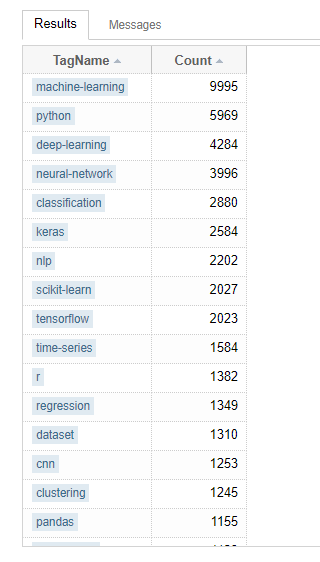

In [1]:
from IPython import display
display.Image("./tags_table.png")

The image above shows the top 20 results from the DSSE db `tags` table. 

The `Tags` table is promising since the top 5 tags is used on about 27000 (85%) of the questions on DSSE. The `machine-learning` tag is particularly promising. `python` is the second highest but we would need more information about what exactly the python questions are about. It indicated strongly that python is the way to go in our content. R ranks much lower in tag usage.  

The `ViewCount` column from the `Posts` table is also useful for us. It shows which questions have received the most views. These posts also have relatively few comments on them according to the `CommentCount` column.  

Another column of interest is the `FavoriteCount` column. It could be worthwhile to do a writeup of post topics that many users have favoured, indicating they find them valuable.

The `AnswerCount` column from the `Posts` table shows that many highly viewed questions only have 5 or less answers. 

In summary, we will be focusing on the following columns from the `Posts` table:
- `Id` - Identification number of the post
- `PostTypeId` - Identification number for the type of post. Only the `Question` and `Answer` posts are relevant to us.
- `CreationDate` - Time and date of post creation. Since we are interested in recent posts we will limit ourselves to 2021.
- `Score` - The score of the post
- `ViewCount` - The number of times the post has been viewed
- `Tags` - What tags the post uses
- `AnswerCount` - How many answer a question-type post has received
- `FavoriteCount` - How many times a question-type post has been favored

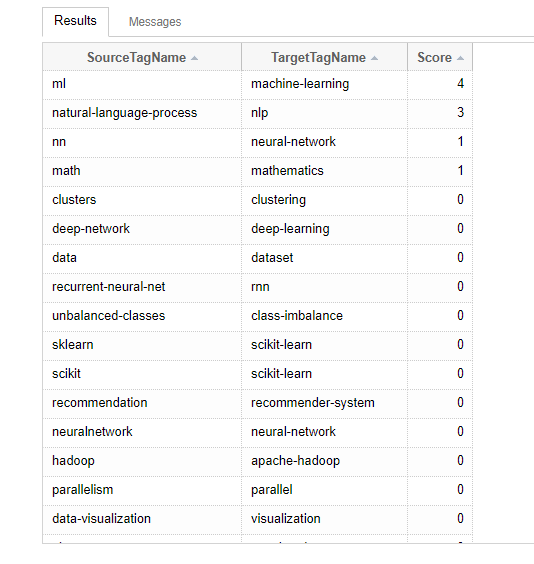

In [2]:
display.Image("./tagsynonyms_table.png")

The image above shows the `TagSynonyms` table. We can see that we will need to account for the popular tag synonyms if we are going to be using tags as metric to base our recommendations on.

We get the information we want from the public database (in .csv format) by running the following SQL query:

```
SELECT TOP 50
      Id,
      PostTypeId,
      CreationDate,
      ViewCount,
      AnswerCount,
      FavoriteCount,
      Score,
      Tags
  FROM Posts
 WHERE DATEPART(YYYY,[CreationDate])='2021' AND PostTypeID = 1
```

## 2.0 Import Data, Install Dependencies and Explore the Data

In [3]:
import pandas as pd
import numpy as np
import datetime as dt
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
dsse = pd.read_csv('dsse_stack_exchange.csv')

display(dsse.head(10))
display(dsse.shape)
display(dsse.dtypes)
display(dsse.isnull().sum())

,Id,PostTypeId,CreationDate,ViewCount,AnswerCount,FavoriteCount,Score,Tags
0,92721,1,2021-04-07 20:11:39,35,1,1.0,1,<deep-learning><cnn><cross-validation>
1,92724,1,2021-04-07 20:33:18,713,1,NaN,0,<finetuning><torchvision>
2,92730,1,2021-04-08 04:41:11,47,1,NaN,-2,<python>
3,92731,1,2021-04-08 06:57:26,29,0,NaN,1,<machine-learning><deep-learning><gpu>
4,92732,1,2021-04-08 07:51:18,35,0,NaN,0,<clustering><image-classification><dbscan>
5,92733,1,2021-04-08 07:52:26,61,3,1.0,1,<machine-learning><deep-learning><time-series>...
6,92734,1,2021-04-08 08:04:24,70,0,NaN,0,<deep-learning><neural-network><transformer><a...
7,92735,1,2021-04-08 08:13:45,16,0,NaN,0,<machine-learning><scikit-learn><predictive-mo...
8,92738,1,2021-04-08 08:28:48,17,0,1.0,0,<machine-learning><cnn><convolutional-neural-n...
9,92740,1,2021-04-08 10:23:13,32,1,NaN,0,<nlp><word-embeddings><word2vec><ai><vector-sp...


(6631, 8)

Id                 int64
PostTypeId         int64
CreationDate      object
ViewCount          int64
AnswerCount        int64
FavoriteCount    float64
Score              int64
Tags              object
dtype: object

Id                  0
PostTypeId          0
CreationDate        0
ViewCount           0
AnswerCount         0
FavoriteCount    6075
Score               0
Tags                0
dtype: int64

## 3.0 Data Cleaning

None of the columns have null values except for `FavoriteCount`. We will replace the null values with zero and convert the column to `int64` type.  

The `CreationDate` column will have to be changed to a datetime type.  

The `Tags` column will be altered to use `,` separation between the tags.

In [4]:
pattern = r"\>(?=[^>]*\>)"

dsse['FavoriteCount'].fillna(value=0, inplace=True)
dsse['FavoriteCount'] = dsse['FavoriteCount'].astype(int)
dsse['CreationDate'] = pd.to_datetime(dsse['CreationDate'])
dsse['Tags'] = dsse['Tags'].str.replace(pattern, ',', regex=True).str.replace('>', '', regex=True).str.replace('<', '', regex=True)

display(dsse.head(10))
display(dsse.dtypes)
display(dsse.isnull().sum())

,Id,PostTypeId,CreationDate,ViewCount,AnswerCount,FavoriteCount,Score,Tags
0,92721,1,2021-04-07 20:11:39,35,1,1,1,"deep-learning,cnn,cross-validation"
1,92724,1,2021-04-07 20:33:18,713,1,0,0,"finetuning,torchvision"
2,92730,1,2021-04-08 04:41:11,47,1,0,-2,python
3,92731,1,2021-04-08 06:57:26,29,0,0,1,"machine-learning,deep-learning,gpu"
4,92732,1,2021-04-08 07:51:18,35,0,0,0,"clustering,image-classification,dbscan"
5,92733,1,2021-04-08 07:52:26,61,3,1,1,"machine-learning,deep-learning,time-series,pre..."
6,92734,1,2021-04-08 08:04:24,70,0,0,0,"deep-learning,neural-network,transformer,atten..."
7,92735,1,2021-04-08 08:13:45,16,0,0,0,"machine-learning,scikit-learn,predictive-model..."
8,92738,1,2021-04-08 08:28:48,17,0,1,0,"machine-learning,cnn,convolutional-neural-network"
9,92740,1,2021-04-08 10:23:13,32,1,0,0,"nlp,word-embeddings,word2vec,ai,vector-space-m..."


Id                        int64
PostTypeId                int64
CreationDate     datetime64[ns]
ViewCount                 int64
AnswerCount               int64
FavoriteCount             int32
Score                     int64
Tags                     object
dtype: object

Id               0
PostTypeId       0
CreationDate     0
ViewCount        0
AnswerCount      0
FavoriteCount    0
Score            0
Tags             0
dtype: int64

## 4.0 Data Analysis

We will start by looking at tags. We will check which tags are the most used, as well as which tags are used on the questions that are most viewed.

In [5]:
# assigning `Tags` to separate df for processing

questions = pd.DataFrame(dsse[["Tags", "ViewCount"]])
questions

,Tags,ViewCount
0,"deep-learning,cnn,cross-validation",35
1,"finetuning,torchvision",713
2,python,47
3,"machine-learning,deep-learning,gpu",29
4,"clustering,image-classification,dbscan",35
...,...,...
6626,"machine-learning,python,scikit-learn,data,numpy",14
6627,"deep-learning,overfitting",35
6628,"feature-selection,markov-hidden-model",56
6629,"machine-learning,linear-regression,cost-function",18


In [6]:
#counting how many times each tag has been used

questions['Tags'] = questions['Tags'].str.split(',') #turning strings into lists
questions['Tags'] = questions['Tags'].explode(ignore_index=True) #turn list elements into rows
tag_use = questions['Tags'].value_counts()
tag_use.head(10)

machine-learning    570
python              383
deep-learning       342
neural-network      200
keras               183
tensorflow          169
nlp                 166
classification      156
scikit-learn        119
time-series         113
Name: Tags, dtype: int64

In [7]:
# Counting how many times each tag has been viewed

tag_views = questions.groupby('Tags')['ViewCount'].sum().sort_values(ascending=False)
tag_views.head(10)

Tags
machine-learning          40939
python                    32616
deep-learning             26542
tensorflow                15351
keras                     15121
attention-mechanism       13476
neural-network            13192
dataset                   12426
classification            12149
machine-learning-model    11911
Name: ViewCount, dtype: int64

## 4.1 Visualizing Tag Use and Tag Views

Let's plot the results we got above.  
First we will plot the top 10 most viewed tags.

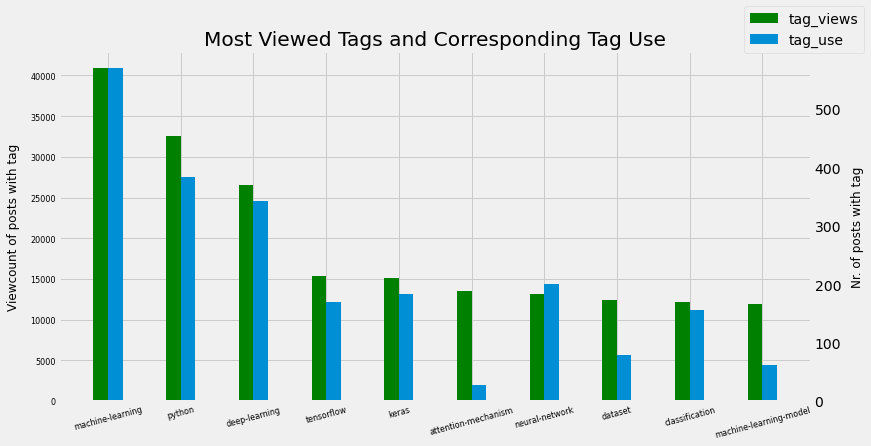

In [22]:
tags = pd.DataFrame({'tag_views': tag_views, 'tag_use': tag_use})
tags10 = tags.sort_values(by='tag_views', ascending=False).head(10)

# plotting the whole graph and adjusting parameters
labels = tags10.index
lab_len = np.arange(len(labels)) #location of the labels
width = 0.20 #width of bars

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)

ax1.bar(lab_len - width/2, height = tags10['tag_views'], width=width, label = 'tag_views', color='green')
ax1.set_xticks(lab_len, labels)

ax2 = ax1.twinx() #creating new y-axis in same figure

ax2.bar(lab_len + width/2, height = tags10['tag_use'], width=width, label = 'tag_use')
ax2.set_xticks(lab_len, labels)

# adjusting plot
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 15) #rotate x-tick labels
ax2.grid() # turn off grid on second y-axis
ax1.set_ylabel('Viewcount of posts with tag', fontsize = 12, labelpad = 10)
ax2.set_ylabel('Nr. of posts with tag', fontsize = 12, labelpad = 10)
ax1.set_title("Most Viewed Tags and Corresponding Tag Use")
fig.legend()



plt.show()


The `tag_views` bar shows the total nr. of views on posts with the various tags, plotted against the left y-axis.  
The `tag_use` bar shows the nr. of posts that use a particular tag, plotted against the right y-axis.

Let's plot the most frequently used tags.

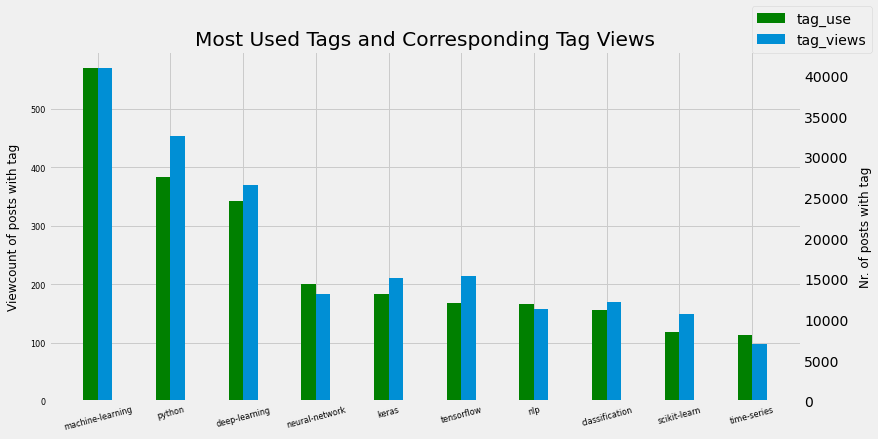

In [23]:
tags10 = tags.sort_values(by='tag_use', ascending=False).head(10)

# plotting the whole graph and adjusting parameters
labels = tags10.index
#[ 'matplotlib', 'convolutional-neural-network', 'numpy', 'transformer', 'dataset', 'tensorflow', 'python-3.x', 'dataframe', 'seaborn', 'pandas']
lab_len = np.arange(len(labels)) #location of the labels
width = 0.20 #width of bars

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots()
fig.set_size_inches(12, 6)
ax1.bar(lab_len - width/2, height = tags10['tag_use'], width=width, label = 'tag_use', color='green')
ax1.set_xticks(lab_len, labels)

ax2 = ax1.twinx() #creating new y-axis in same figure

ax2.bar(lab_len + width/2, height = tags10['tag_views'], width=width, label = 'tag_views')
ax2.set_xticks(lab_len, labels)

# adjusting plot
ax1.tick_params(axis='both', which='major', labelsize=8)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 15) #rotate x-tick labels
ax2.grid() # turn off grid on second y-axis
ax1.set_ylabel('Viewcount of posts with tag', fontsize = 12, labelpad = 10)
ax2.set_ylabel('Nr. of posts with tag', fontsize = 12, labelpad = 10)
ax1.set_title('Most Used Tags and Corresponding Tag Views')
fig.legend()


plt.show()